#### Train RL model

train the model in the simualated environment. During training evaluation data is collected to follow the training.
A2C. 

A synchronous, deterministic variant of Asynchronous Advantage Actor Critic (A3C). It uses multiple workers to avoid the use of a replay buffer.

The A2C (Advantage Actor-Critic) algorithm combines elements of both policy gradient methods (Actor) and value function estimation methods (Critic). A2C is an on-policy method, which means it uses the current policy to collect data and update the policy based on that data. The actor is responsible for selecting actions in the environment. It's typically represented as a neural network, and its primary goal is to learn a policy that maps observations to actions. The actor outputs a probability distribution over the available actions and samples actions from this distribution. The critic, on the other hand, estimates the value function. The value function represents the expected cumulative reward that an agent can obtain starting from a given state and following a particular policy. The critic helps the agent evaluate the quality of its actions and states by estimating how good or bad they are.

A2C combines these two components in the following way: 

Data Collection: A2C uses the current policy (actor) to interact with the environment and collects trajectories, which consist of state-action-reward sequences.
Compute Advantage: After collecting data, A2C calculates the advantage for each state-action pair. The advantage measures how much better or worse the agent's actions were compared to the expected value estimated by the critic. This is typically computed as the difference between the actual observed returns and the values estimated by the critic.
Policy Update: A2C updates the policy (actor) by performing policy gradient updates with the computed advantages. This encourages actions that led to better-than-expected outcomes and discourages actions that led to worse-than-expected outcomes.
Value Function Update: The critic's parameters are updated using a loss that minimizes the difference between its value estimates and the actual observed returns. This helps improve the accuracy of value predictions.
Repeat: Steps 1 to 4 are repeated iteratively, allowing the agent to improve its policy and value function over time.

A2C has several advantages:

It is a relatively stable and sample-efficient on-policy method.
It combines the benefits of policy gradients and value function estimation.
It can handle both discrete and continuous action spaces.
However, it may require more data and time for training compared to off-policy methods, and it might be sensitive to hyperparameter choices.


In [25]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys
import pandas as pd
from pathlib import Path
from stable_baselines3 import A2C
from stable_baselines3.common.sb2_compat.rmsprop_tf_like import RMSpropTFLike

# Find the root directory by traversing up the directory tree
def find_project_root(current_path):
    if os.path.exists(os.path.join(current_path, "README.md")):
        return current_path
    parent_path = os.path.dirname(current_path)
    if parent_path == current_path:
        raise ValueError("Project root not found.")
    return find_project_root(parent_path)


current_dir = os.getcwd()
project_root = find_project_root(current_dir)
sys.path.append(str(project_root))
print(f"Project root: {project_root}")

# flake8: noqa  # Disable Flake8 for the following block
import gymnasium as gym
from src.models.bank_env import BankEnv
from src.visualization import visualize
import src.models.train as train
from src.tests import test_bankmodel_a2c_train as tests
from src.data.definitions import MODEL_PATH, TENSORBOARD_LOGS, DATA_MODEL_PATH
from src.models.evaluate import evaluate_policy

Project root: f:\OneDrive\Documents\GitHub\rl-alm


##### First test - just take a random walk in the environment. 

Each episode consists of 60 months. Each timestep interest rates and swap rates are simulated and the bank enters into new mortgages.  
Each month the actor needs to decide on the funding strategy to fund the bank. 

In [2]:
env_id = "bank-v3"
gym.register(id=env_id, entry_point=BankEnv, max_episode_steps=60)


In [3]:
# Random walk in the environment
tests.random_walk(env_id)

2023-10-18 15:45:55.586 | INFO     | src.data.dataset:read_data:45 - reading interest data from ESW.
2023-10-18 15:45:57.511 | INFO     | src.data.dataset:read_data:45 - reading zerocurve data from ESW.


Interest period:  (Timestamp('2010-06-01 00:00:00'), Timestamp('2023-08-01 00:00:00'))
Zerocurve period:  (Timestamp('2010-06-01 00:00:00'), Timestamp('2023-08-01 00:00:00'))
steps: 60, score: -11183


Define the model. For the initial model we use the A2C model. 

In [4]:
env = gym.make(env_id, render_mode="human")

# Define a Lineair Learning Rate Scheduler
def linear_schedule(initial_value: float):
    """Linear learning rate schedule."""

    def func(progress_remaining: float) -> float:
        """Progress will decrease from 1 (beginning) to 0."""
        return progress_remaining * initial_value

    return func

initial_lr = 0.001
n_steps = 60
model_name = 'A2C'
ent_coef= 0.001

# RMSpropTFLike is an optimizer to increase stability of training
policy_kwargs=dict(optimizer_class=RMSpropTFLike, optimizer_kwargs=dict(eps=1e-5))


model = A2C(
        "MultiInputPolicy",        
        env,
        device="cpu",
        tensorboard_log=TENSORBOARD_LOGS,
        verbose=0,
        n_steps=n_steps,
        learning_rate=linear_schedule(initial_lr),
        ent_coef=ent_coef,
        policy_kwargs = policy_kwargs,        
    )

2023-10-18 15:46:04.235 | INFO     | src.data.dataset:read_data:45 - reading interest data from ESW.
2023-10-18 15:46:05.578 | INFO     | src.data.dataset:read_data:45 - reading zerocurve data from ESW.


Interest period:  (Timestamp('2010-06-01 00:00:00'), Timestamp('2023-08-01 00:00:00'))
Zerocurve period:  (Timestamp('2010-06-01 00:00:00'), Timestamp('2023-08-01 00:00:00'))


##### Train the model in the environment and save it

f:\OneDrive\Documents\GitHub\rl-alm\venv\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.reset_episode_statistics to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.reset_episode_statistics` for environment variables or `env.get_wrapper_attr('reset_episode_statistics')` that will search the reminding wrappers.
  logger.warn(
f:\OneDrive\Documents\GitHub\rl-alm\venv\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.episode_rewards to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.episode_rewards` for environment variables or `env.get_wrapper_attr('episode_rewards')` that will search the reminding wrappers.
  logger.warn(


Model name: A2C, Steps: 600000, Mean: 721.9838, IQR: 294.0, CVaR: -552.5473684210526


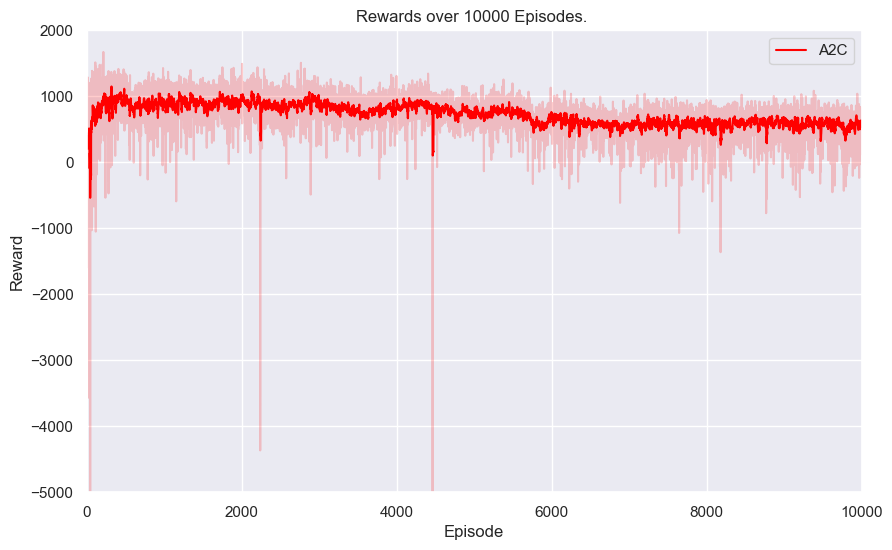

In [26]:
steps = 600_000
 
model, mean, episode_iqr, episode_cvar, episode_rewards = train.train( model, env, total_timesteps=steps, conf_level=0.95, tb_log_name= TENSORBOARD_LOGS)
modelpath = Path(    
        MODEL_PATH,
        model_name + "_" + str(steps) + ".zip",
    )

model.save(modelpath)
pd.DataFrame(episode_rewards).to_csv(Path(DATA_MODEL_PATH, model_name + "_" + str(steps) + ".csv"))

print(f"Model name: {model_name}, Steps: {steps}, Mean: {mean}, IQR: {episode_iqr}, CVaR: {episode_cvar}")
visualize.plot_rewards(episode_rewards, interpolate_line=False, rolling_line= True, ylim=(-5000,2000),
                       label = model_name, title = f"Rewards over {int(steps/60)} Episodes. ")


In [17]:
print(model.policy)

MultiInputActorCriticPolicy(
  (features_extractor): CombinedExtractor(
    (extractors): ModuleDict(
      (liquidity): Flatten(start_dim=1, end_dim=-1)
      (cashflows): Flatten(start_dim=1, end_dim=-1)
      (swap_rates): Flatten(start_dim=1, end_dim=-1)
      (bank_rates): Flatten(start_dim=1, end_dim=-1)
      (features): Flatten(start_dim=1, end_dim=-1)
    )
  )
  (pi_features_extractor): CombinedExtractor(
    (extractors): ModuleDict(
      (liquidity): Flatten(start_dim=1, end_dim=-1)
      (cashflows): Flatten(start_dim=1, end_dim=-1)
      (swap_rates): Flatten(start_dim=1, end_dim=-1)
      (bank_rates): Flatten(start_dim=1, end_dim=-1)
      (features): Flatten(start_dim=1, end_dim=-1)
    )
  )
  (vf_features_extractor): CombinedExtractor(
    (extractors): ModuleDict(
      (liquidity): Flatten(start_dim=1, end_dim=-1)
      (cashflows): Flatten(start_dim=1, end_dim=-1)
      (swap_rates): Flatten(start_dim=1, end_dim=-1)
      (bank_rates): Flatten(start_dim=1, end_di

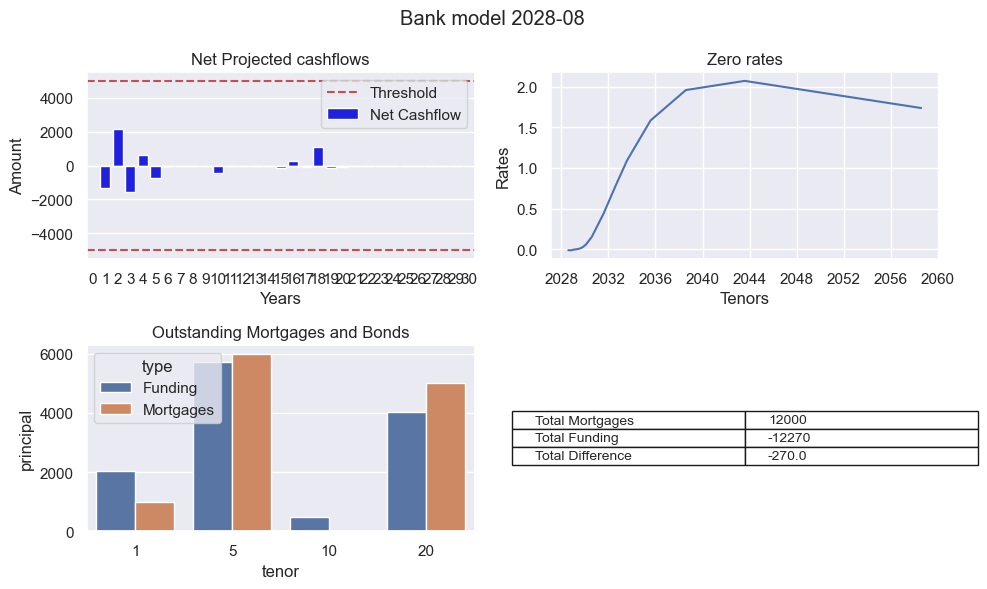

final score:  524


,timestep,reward,risk_penalty,liquidity_penalty,liquidity,nii,income,funding_cost,total_funding,total_mortgages
0,1,0,0,0,112.537857,0,0.000000,-0.240245,-112,0
1,2,0,0,0,112.537857,0,0.000000,-0.240245,-112,0
2,3,0,0,0,450.049820,0,0.000000,-0.803359,-449,0
3,4,0,0,0,450.049820,0,0.000000,-0.803359,-449,0
4,5,0,0,0,476.513746,0,0.000000,-0.855085,-475,0
5,6,0,0,0,476.513746,0,0.000000,-0.855085,-475,0
6,7,0,0,0,476.513746,0,0.000000,-0.855085,-475,0
7,8,-1,0,0,653.770750,-1,0.000000,-1.025154,-652,0
8,9,-1,0,0,982.267332,-1,0.000000,-1.650546,-980,0
9,10,-1,0,0,982.267332,-1,0.000000,-1.650546,-980,0


In [18]:
def show_model(env, model) -> int:
    """Show the model in the environment"""        
    # env.set_render_output(modelpath.stem)
    obs, info = env.reset()
    score = 0
    terminated = False
    truncated = False
    # env.set_render_output('A2C')

    while not terminated and not truncated:
        action, _state = model.predict(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        score = score + reward
        # env.render()
        df = env.list_model()    
    env.plot()
    env.close()    
    return score, df

score, df = show_model(env, model)
print ('final score: ', score)
df.head(60)

In [19]:
mean_reward, irq, es, rewards = evaluate_policy(model, env, n_eval_episodes=500)

In [20]:
print(f"number of episodes = {len(rewards)}, mean_reward={mean_reward:.2f} Expected Shortfall={es:.2f} Interquartile Range={irq:.2f}")

number of episodes = 500, mean_reward=741.97 Expected Shortfall=-135.20 Interquartile Range=207.50


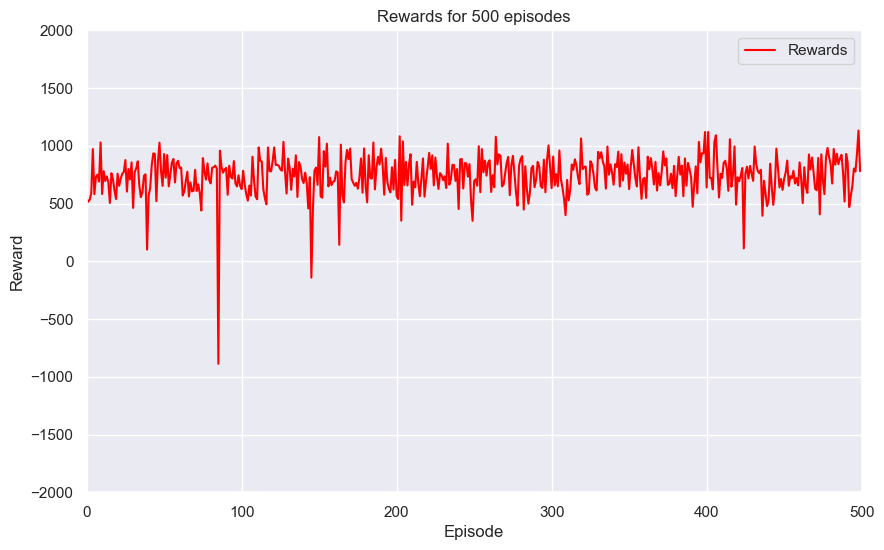

In [21]:
visualize.plot_rewards(rewards, interpolate_line=False)